In [1]:
import numpy as np 
from numpy import array
import pandas as pd 
import matplotlib.pyplot as plt  
from matplotlib import pyplot   
import seaborn as sns  
import pickle  

import warnings
warnings.filterwarnings("ignore")
# Standardizer,   One hot Encoder MinMaxScaler,LabelEncoder library
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder, OneHotEncoder   
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#from scipy.sparse import csr_matrix  

from sklearn.model_selection import train_test_split
# Different Models

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  
from sklearn.metrics import precision_score, recall_score, accuracy_score
%matplotlib inline
import os
import time

from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.patches as patches
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [5]:
# Define the path to the Kaggle dataset
data_path = '/kaggle/input/full-cicids2017/MachineLearningCVE/'

# Initialize an empty list to store the DataFrames
ls = []

# Loop through the files in the specified Kaggle directory
for filename in os.listdir(data_path):
    if filename.endswith('.csv'):
        print(filename)
        
        # Create the full file path
        file_path = os.path.join(data_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Append the DataFrame to the list
        ls.append(df)
        
        # Print the shape and unique labels of the DataFrame
        print(f'Shape: {df.shape}. Attack Type {df[" Label"].unique()}')


Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Shape: (286467, 79). Attack Type ['BENIGN' 'PortScan']
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Shape: (170366, 79). Attack Type ['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']
Tuesday-WorkingHours.pcap_ISCX.csv
Shape: (445909, 79). Attack Type ['BENIGN' 'FTP-Patator' 'SSH-Patator']
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Shape: (225745, 79). Attack Type ['BENIGN' 'DDoS']
Monday-WorkingHours.pcap_ISCX.csv
Shape: (529918, 79). Attack Type ['BENIGN']
Friday-WorkingHours-Morning.pcap_ISCX.csv
Shape: (191033, 79). Attack Type ['BENIGN' 'Bot']
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Shape: (288602, 79). Attack Type ['BENIGN' 'Infiltration']
Wednesday-workingHours.pcap_ISCX.csv
Shape: (692703, 79). Attack Type ['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']


In [6]:
df = pd.concat(ls)
df.head(3)
assert df.shape[1] == 79 #  is checking if the number of columns in the DataFrame df is equal to 79. 

### Remove space from culumn names 

In [7]:
df.columns = df.columns.str.strip()
print("original length of df:", len(df))

original length of df: 2830743


# Check for Missing Values

In [8]:
df.isnull().sum().sum()

1358

### Remove missing value culumn names 

In [9]:
# remove missing columns and rows 
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

after droping null values, the length of df: 2827876


In [10]:
df.isnull().sum().sum() 

0

In [11]:
df.Label.value_counts()
# del df

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

# Merge few minority attack classes having  similar characteristics and behavior.

In [12]:
df['Label'].unique()

array(['BENIGN', 'PortScan', 'Web Attack � Brute Force',
       'Web Attack � XSS', 'Web Attack � Sql Injection', 'FTP-Patator',
       'SSH-Patator', 'DDoS', 'Bot', 'Infiltration', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

In [13]:
df_ids2017 = df.copy()
df_ids2017.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_ids2017.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_ids2017.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)
df_ids2017.Label.value_counts()

Label
BENIGN          2271320
DoS              251712
PortScan         158804
DDoS             128025
Brute Force       13832
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [14]:
df_ids2017['Label'].unique()

array(['BENIGN', 'PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot',
       'Infiltration', 'DoS', 'Heartbleed'], dtype=object)

In [15]:
df_ids2017.head(2)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.97561,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.97561,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Scenarion_1 Convert into BInary Classification and Droping Corelated Features 

In [16]:
#df_Binary = df.copy()
df_ids2017.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_ids2017.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_ids2017.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)
df_ids2017.Label.value_counts()

Label
BENIGN          2271320
DoS              251712
PortScan         158804
DDoS             128025
Brute Force       13832
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [20]:
df_ids2017

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692698,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692699,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692700,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692701,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [17]:
df_ids2017['Label'].unique()

array(['BENIGN', 'PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot',
       'Infiltration', 'DoS', 'Heartbleed'], dtype=object)

In [18]:
df_ids2017['Label'].replace({'PortScan': 'attack', 'Web Attack':'attack',
                            'Brute Force': 'attack',
                            'DDoS':'attack' , 'Bot':'attack',
                            'Infiltration':'attack',
                            'DoS':'attack', 'Heartbleed':'attack'}, inplace=True)

In [19]:
df_ids2017['Label'].unique()

array(['BENIGN', 'attack'], dtype=object)

In [20]:
pd.value_counts(df_ids2017['Label'].values)

BENIGN    2271320
attack     556556
Name: count, dtype: int64

In [21]:
df_ids2017

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692698,53,32215,4,2,112,152,28,28,28.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692699,53,324,2,2,84,362,42,42,42.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692700,58030,82,2,1,31,6,31,0,15.500000,21.920310,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
692701,53,1048635,6,2,192,256,32,32,32.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [22]:
df_ids2017.to_csv('./BINARY_CICIDS2017_All_Dataset.csv')

In [2]:
df = pd.read_csv('//kaggle/input/binary-cicids2017-all-dataset/BINARY_CICIDS2017_All_Dataset.csv')

### Label encoding of BENIGN and  attack 

In [3]:
df_ids2017 = df

In [4]:
le_target = LabelEncoder()
df_ids2017.Label =le_target.fit_transform(df_ids2017.Label)
#df_Binary['Label'] = le_target.fit_transform(df_Binary['Label'])

In [5]:
pd.value_counts(df_ids2017['Label'].values)

0    2271320
1     556556
Name: count, dtype: int64

In [6]:
X = df_ids2017.drop('Label', axis=1)
y = df_ids2017['Label']

In [7]:
# First, undersample the majority class to 1,414,698
rus = RandomUnderSampler(sampling_strategy={0: 1414698}, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Then, oversample the minority class to 1,414,698
ros = RandomOverSampler(sampling_strategy={1: 1414698}, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

# Check the new class distribution
print(pd.Series(y_resampled).value_counts())


Label
0    1414698
1    1414698
Name: count, dtype: int64


In [8]:
X_resampled.shape, y_resampled.shape

((2829396, 79), (2829396,))

###  Splitting data into train and test -Scenario 1


In [9]:
# data split
x_train_input, x_test_input, y_train_target, y_test_target = train_test_split(X_resampled, y_resampled,test_size=0.30,random_state=42, stratify=y_resampled)
print("after spliting the data:\n")
print("training data input length:", len(x_train_input))
print("test data input  length:", len(x_test_input))
# print(y_train.nunique())
# print(y_train.value_counts())

after spliting the data:

training data input length: 1980577
test data input  length: 848819


In [10]:
x_train_input.shape, y_train_target.shape, x_test_input.shape, y_test_target.shape

((1980577, 79), (1980577,), (848819, 79), (848819,))

### Correlation of Dataset 

<Axes: >

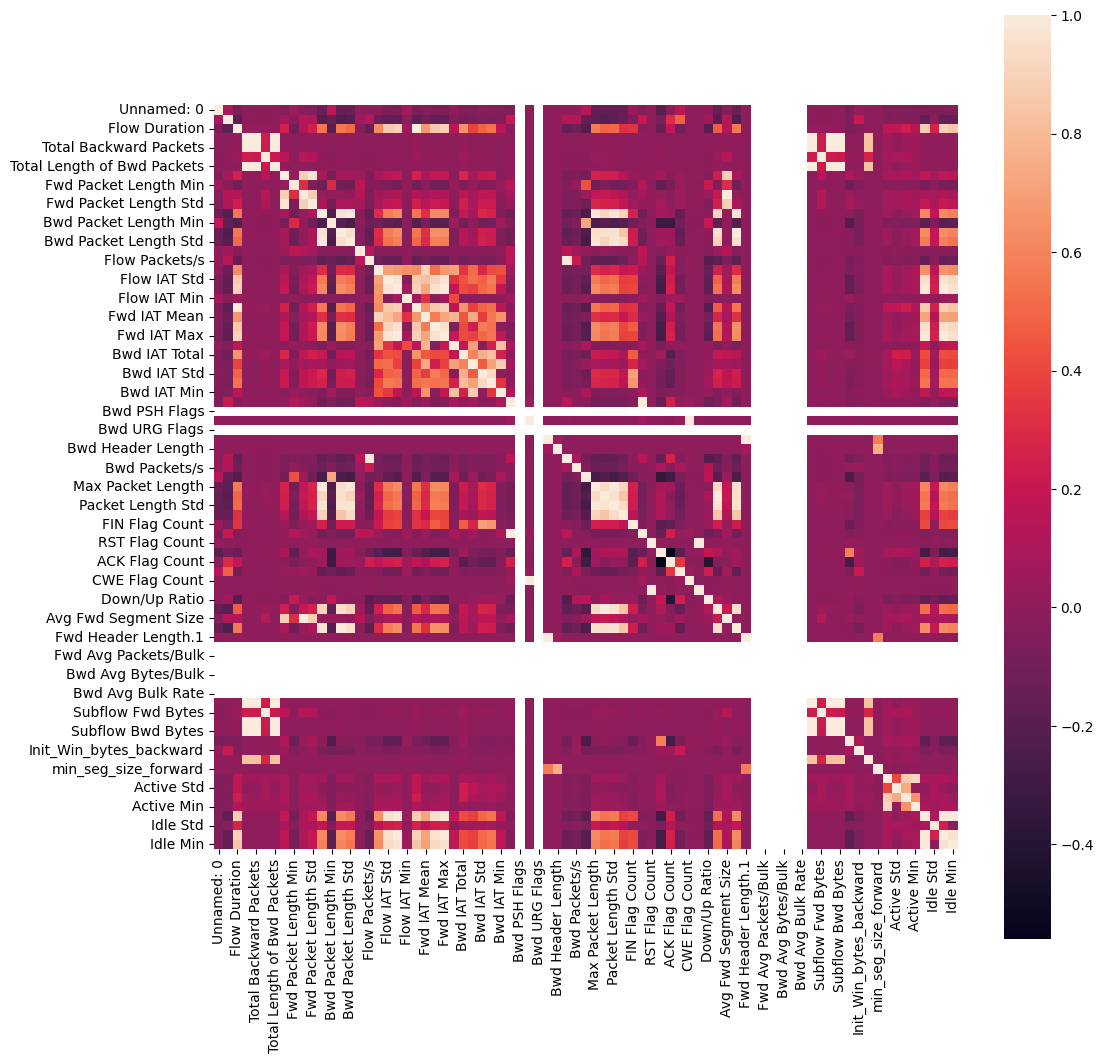

In [11]:
# Plotting the correlation matrix of the dataset
# Refer: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
method_1 = "pearson"
# correlation matrix
corr_matr = x_train_input.corr(method=method_1)
plt.figure(figsize=(12,12)) 
sns.heatmap(corr_matr, square=True)
#plt.show()

In [12]:
# Getting and printing high correlated features
threshold = 0.99 #0.96

columns = corr_matr.columns
for i in range(corr_matr.shape[0]):
    for j in range(i+1, corr_matr.shape[0]):
        if corr_matr.iloc[i, j] >= threshold:
            print(f"{columns[i]:30s} {columns[j]:30s} {corr_matr.iloc[i, j]}")

Flow Duration                  Fwd IAT Total                  0.9992181632404021
Total Fwd Packets              Total Backward Packets         0.9990851025887227
Total Fwd Packets              Total Length of Bwd Packets    0.9972000678445619
Total Fwd Packets              Subflow Fwd Packets            1.0
Total Fwd Packets              Subflow Bwd Packets            0.9990851025887227
Total Fwd Packets              Subflow Bwd Bytes              0.9971947787163327
Total Backward Packets         Total Length of Bwd Packets    0.9948207895463598
Total Backward Packets         Subflow Fwd Packets            0.9990851025887227
Total Backward Packets         Subflow Bwd Packets            1.0
Total Backward Packets         Subflow Bwd Bytes              0.9948153448469836
Total Length of Fwd Packets    Subflow Fwd Bytes              0.9999994546796083
Total Length of Bwd Packets    Subflow Fwd Packets            0.9972000678445619
Total Length of Bwd Packets    Subflow Bwd Packets        

In [13]:
#Reference: https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection 
#with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature
def correlation_2(dataset, threshold):
    col_cor = set()  # Set of all the names of correlated columns
    corr_matrix_2 = x_train_input.corr().abs()
    for i in range(len(corr_matrix_2.columns)):
        for j in range(i):
            if abs(corr_matrix_2.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix_2.columns[i]  # getting the name of column
                col_cor.add(colname)
    return col_cor

In [14]:
corr_features_2 = correlation_2(x_train_input, 0.92) # 90->acc 98.83 #96 acc 99.97
len(set(corr_features_2))

29

In [15]:
corr_features_2

{'Average Packet Size',
 'Avg Bwd Segment Size',
 'Avg Fwd Segment Size',
 'Bwd IAT Max',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'CWE Flag Count',
 'ECE Flag Count',
 'Flow IAT Max',
 'Fwd Header Length.1',
 'Fwd IAT Max',
 'Fwd IAT Std',
 'Fwd IAT Total',
 'Fwd Packet Length Std',
 'Fwd Packets/s',
 'Idle Max',
 'Idle Mean',
 'Idle Min',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'SYN Flag Count',
 'Subflow Bwd Bytes',
 'Subflow Bwd Packets',
 'Subflow Fwd Bytes',
 'Subflow Fwd Packets',
 'Total Backward Packets',
 'Total Length of Bwd Packets'}

#### Malicious and Normal class distribution 

In [16]:
y_train_target.value_counts() 

Label
1    990289
0    990288
Name: count, dtype: int64

In [17]:
y_test_target.value_counts() 

Label
0    424410
1    424409
Name: count, dtype: int64

In [18]:
x_train_input_0, y_train_target_1 = y_train_target.value_counts()[0] / len(y_train_target) , y_train_target.value_counts()[1] / len(y_train_target)
x_test_input_0, y_test_target_1 = y_test_target.value_counts()[0] / len(y_test_target), y_test_target.value_counts()[1] /len(y_test_target) 

print("In Train: there are {} % of class 0 and {} % of class 1".format(x_train_input_0, y_train_target_1))
print("In Test: there are {} % of class 0 and {} % of class 1".format(x_test_input_0, y_test_target_1))

In Train: there are 0.49999974754831544 % of class 0 and 0.5000002524516846 % of class 1
In Test: there are 0.5000005890537323 % of class 0 and 0.4999994109462677 % of class 1


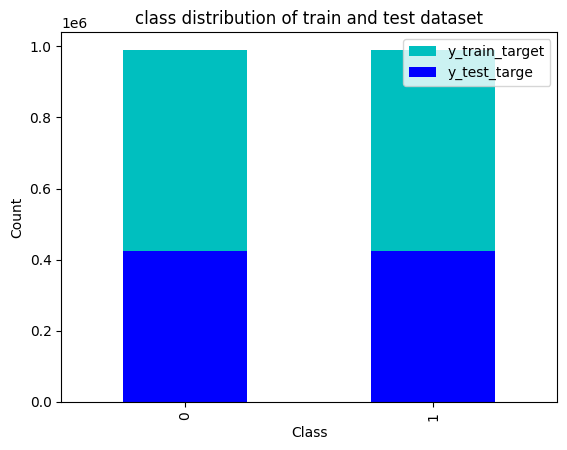

In [19]:
# Plotting target label distribution
#import matplotlib.pyplot as plt
plt.figure()
plt.title("class distribution of train and test dataset")
y_train_target.value_counts().plot(kind="bar", color='c', label="y_train_target")
y_test_target.value_counts().plot(kind="bar", color='blue', label="y_test_targe")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [20]:
#Remove correlated features from train and test dataset 
x_train_input.drop(corr_features_2,axis=1, inplace=True)
x_test_input.drop(corr_features_2,axis=1,inplace=True)

In [ ]:
# save train and test data with taget value 
x_train_input.to_csv('./CICIDS2017_train_clean.csv', index=False)
x_test_input.to_csv('./CICIDS2017_test_clean.csv', index=False)

In [21]:
x_train_input.shape, y_train_target.shape, x_test_input.shape, y_test_target.shape

((1980577, 50), (1980577,), (848819, 50), (848819,))

### Check Missing data after data split

In [22]:
# checking for null values
x_train_input.isnull().sum().sum()

0

In [23]:
x_train_input.isnull().sum().sum(), x_test_input.isnull().sum().sum()

(0, 0)

In [24]:
# check Data type 
x_train_input.dtypes.value_counts()

int64      38
float64    12
Name: count, dtype: int64

### Check the statitstics  value of Train data  

### Standardization or Normalization 
if the data is sandarzided with ScalarStandard it mean is 0 and standard devation is 1  or if it normalized the value range 0 to 1 


In [42]:
x_train_input.describe().round(2)

,Unnamed: 0,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,...,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Idle Std
count,1979057.00,1979057.00,1.979057e+06,1979057.00,1979057.00,1979057.00,1979057.00,1979057.00,1979057.00,1979057.00,...,1979057.0,1979057.0,1979057.00,1979057.00,1979057.00,1.979057e+06,1.979057e+06,1979057.00,1.979057e+06,1979057.00
mean,219186.31,8067.37,1.480603e+07,9.01,547.78,207.64,18.73,58.17,871.66,41.07,...,0.0,0.0,6990.64,1992.25,5.05,-3.593720e+03,8.194345e+04,41362.69,1.538011e+05,505738.84
std,165465.31,18281.14,3.367917e+07,692.63,10787.57,715.79,60.53,185.73,1946.71,68.84,...,0.0,0.0,14338.46,8467.59,569.22,1.286609e+06,6.422486e+05,392653.68,1.024806e+06,4610589.71
min,0.00,0.00,-1.200000e+01,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,-1.00,-1.00,0.00,-5.368707e+08,0.000000e+00,0.00,0.000000e+00,0.00
25%,88375.00,53.00,1.550000e+02,2.00,12.00,6.00,0.00,6.00,2.00,0.00,...,0.0,0.0,-1.00,-1.00,0.00,2.000000e+01,0.000000e+00,0.00,0.000000e+00,0.00
50%,177689.00,80.00,3.133900e+04,2.00,62.00,37.00,2.00,34.00,79.00,0.00,...,0.0,0.0,251.00,-1.00,1.00,2.400000e+01,0.000000e+00,0.00,0.000000e+00,0.00
75%,320289.00,443.00,3.229149e+06,5.00,188.00,81.00,36.00,50.00,282.00,77.00,...,0.0,0.0,8192.00,235.00,2.00,3.200000e+01,0.000000e+00,0.00,0.000000e+00,0.00
max,692701.00,65535.00,1.200000e+08,218658.00,12900000.00,24820.00,2293.00,5940.86,19530.00,2896.00,...,0.0,0.0,65535.00,65535.00,207501.00,1.380000e+02,1.100000e+08,70000000.00,1.100000e+08,76900000.00


In [25]:
scaler_t = MinMaxScaler()
#rescalled value 
x_train_input_SC = scaler_t.fit_transform(x_train_input)
x_test_input_SC = scaler_t.transform(x_test_input)

In [26]:
x_train_input_SC.max().round()

1.0

In [27]:
x_train_input_SC.min().round(2)

0.0

# SMOTE

In [ ]:
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
# Check shapes before SMOTE
print("Shapes before SMOTE:")
print(x_train_input_SC.shape, y_train_target.shape, x_test_input_SC.shape, y_test_target.shape)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_input_SC, y_train_target)

# Check shapes after SMOTE
print("Shapes after SMOTE:")
print(x_train_smote.shape, y_train_smote.shape)

In [24]:
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# Check shapes before SMOTE
print("Shapes before SMOTE:")
print(x_train_input_SC.shape, y_train_target.shape, x_test_input_SC.shape, y_test_target.shape)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_input_SC, y_train_target)

# Check shapes after SMOTE
print("Shapes after SMOTE:")
print(x_train_smote.shape, y_train_smote.shape)

# Combine x_train_smote and y_train_smote to perform consistent sampling
train_data = list(zip(x_train_smote, y_train_smote))

# If the number of samples after SMOTE is greater than 848,819, undersample
if len(y_train_smote) > 848819:
    train_data_resampled = resample(train_data, n_samples=848819, random_state=42)

# If the number of samples after SMOTE is less than 848,819, oversample
elif len(y_train_smote) < 848819:
    train_data_resampled = resample(train_data, n_samples=848819, replace=True, random_state=42)

# Unzip the resampled data back into x_train_smote and y_train_smote
x_train_smote_resampled, y_train_smote_resampled = zip(*train_data_resampled)

# Convert back to numpy arrays
x_train_smote_resampled = np.array(x_train_smote_resampled)
y_train_smote_resampled = np.array(y_train_smote_resampled)

# Check shapes after adjusting to 848,819
print("Shapes after adjusting to 848,819:")
print(x_train_smote_resampled.shape, y_train_smote_resampled.shape)



Shapes before SMOTE:
(1979057, 55) (1979057,) (848819, 55) (848819,)
Shapes after SMOTE:
(3179116, 55) (3179116,)
Shapes after adjusting to 848,819:
(848819, 55) (848819,)


In [28]:
x_train_input_SC.round(3)

array([[0.172, 0.001, 0.708, ..., 0.   , 0.   , 0.   ],
       [0.216, 0.613, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.124, 0.007, 0.001, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.158, 0.001, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.755, 0.024, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.676, 0.864, 0.   , ..., 0.   , 0.   , 0.   ]])

In [66]:
import numpy as np
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam

def create_autoencoder(input_dim, encoding_dim, l1_reg, l2_reg, learning_rate):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu', activity_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    decoded = Dense(32, activation='relu')(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    
    optimizer = Adam(learning_rate=learning_rate)
    
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return autoencoder, encoder

# Random search

def random_search(X_train_input_SC, hyperparameter_ranges, n_iter):
    best_params = None
    best_mse = float('inf')

    for _ in range(n_iter):
        config = {param: np.random.choice(options) for param, options in hyperparameter_ranges.items()}
        model, _ = create_autoencoder(input_dim=x_train_input_SC.shape[1], encoding_dim=config['encoding_dim'],
                                   l1_reg=config['l1_reg'], l2_reg=config['l2_reg'], learning_rate=config['learning_rate'])
        history = model.fit(x_train_input_SC, x_train_input_SC, epochs=config['num_epochs'],
                            batch_size=config['batch_size'], verbose=0, validation_split=0.3)
        mse = history.history['val_loss'][-1]

        if mse < best_mse:
            best_mse = mse
            best_params = config

    return best_params, best_mse

# Search parameter spaces
hyperparameter_ranges = {
    'batch_size': [128], #[32,64,256,1024],  
    'l1_reg': [0.0001], #[0.01,0.001,0.0001],
    'l2_reg': [0.001], #[0.01,0.001,0.0001],
    'encoding_dim': [32], # [16,32]
    'num_epochs': [100],  # 25 # [50,75,100,150],Increase the number of epochs
    'learning_rate': [0.0001],  # [0.0001,0.001,0.01, 0.02] Lower the learning rate
}

# Perform random search
best_params, best_mse = random_search(x_train_input_SC, hyperparameter_ranges, n_iter=1) # SET UPTO MAX 15

# Print or store the best configuration and performance
print("Best Configuration:", best_params)
print("Best MSE:", best_mse)

# Create the autoencoder model with the best hyperparameters
best_autoencoder, best_encoder = create_autoencoder(input_dim=x_train_input_SC.shape[1], encoding_dim=best_params['encoding_dim'],
                                                    l1_reg=best_params['l1_reg'], l2_reg=best_params['l2_reg'], learning_rate=best_params['learning_rate'])

# Train the best model on the entire training dataset
history = best_autoencoder.fit(x_train_input_SC, x_train_input_SC, epochs=best_params['num_epochs'],
                                batch_size=best_params['batch_size'], verbose=0, shuffle=True, validation_split=0.3)

# Evaluate the model on test data
mse_test = best_autoencoder.evaluate(x_test_input_SC, x_test_input_SC, verbose=0)

print("Test MSE:", mse_test)
# print("Test MAE Percentage:", mae_test)

# Use the encoder for feature representation
encoded_features = best_encoder.predict(x_test_input_SC)
print("Encoded Features Shape:", encoded_features.shape)

X_Mae = best_autoencoder.predict(x_test_input_SC)
mae_test = np.mean(np.abs(x_test_input_SC - X_Mae))
print("Test MAE:", mae_test)

Best Configuration: {'batch_size': 128, 'l1_reg': 0.0001, 'l2_reg': 0.001, 'encoding_dim': 32, 'num_epochs': 100, 'learning_rate': 0.0001}
Best MSE: 0.002482389798387885
Test MSE: 0.0004624704597517848
26526/26526 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
Encoded Features Shape: (848819, 32)
26526/26526 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step
Test MAE: 0.005607439036702069


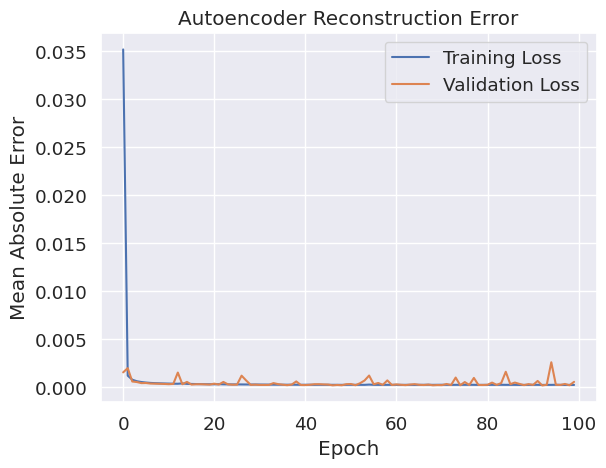

In [67]:
# Plot the reconstruction error
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Reconstruction Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('FINAL_CICIDS2017_COMP_Validation loss_Final_MAE_MSE.png')
plt.show()

In [68]:
encoded_features_train_EDA = best_autoencoder.predict(x_train_input_SC)
encoded_features_test_EDA = best_autoencoder.predict(x_test_input_SC)

61894/61894 ━━━━━━━━━━━━━━━━━━━━ 91s 1ms/step
26526/26526 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


In [ ]:
# this is with the whole autoencoder
import matplotlib.pyplot as plt

scatter = plt.scatter(encoded_features_train_EDA[:, 1], encoded_features_train_EDA[:, 0], c=y_train_target, cmap='viridis')
# Add a colorbar
plt.colorbar(scatter, label='Class')
plt.title('Encoded Features Visualization')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.savefig('FINAL_BEst_FeE_Vclass2_01.png')
plt.show()

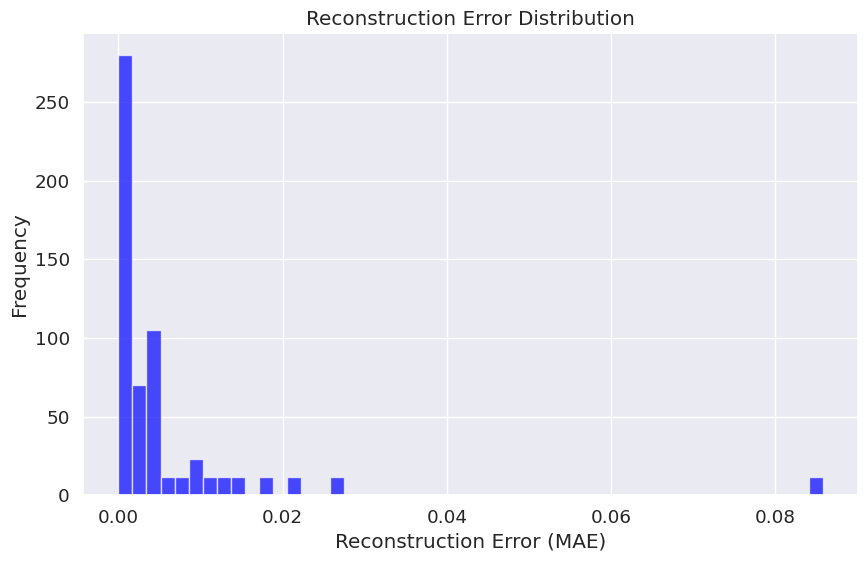

In [69]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assuming scaled_X_train is your original data, and encoded_features_train_EDA is the reconstructed data

# Calculate the reconstruction error for each data point
reconstruction_error = mean_absolute_error(x_train_input_SC, encoded_features_train_EDA, multioutput='raw_values')

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error (MAE)')
plt.ylabel('Frequency')
plt.savefig('FINAL_CICIDS2017_new_Final_MAE_Encode_Recon_Error.png')
plt.show()

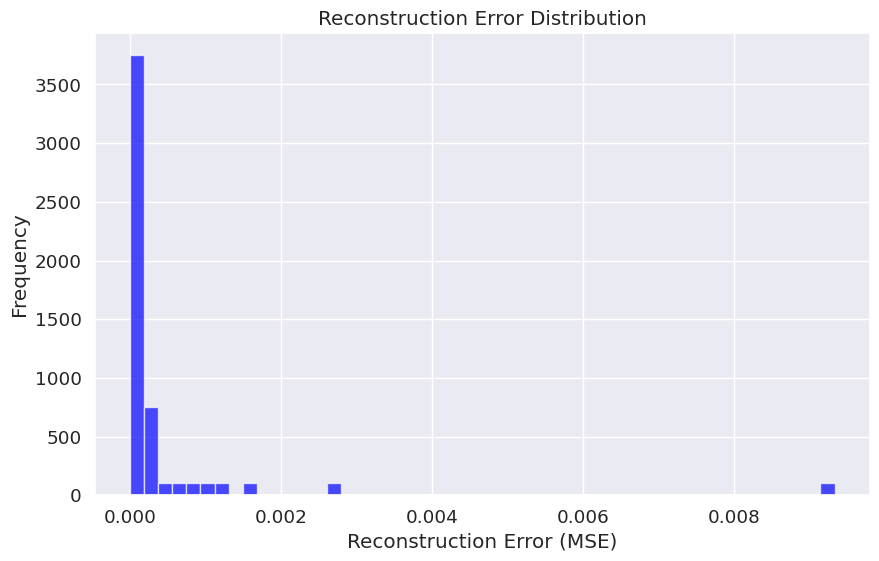

In [70]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming scaled_X_train is your original data, and encoded_features_train_EDA is the reconstructed data

# Calculate the reconstruction error for each data point
reconstruction_error = mean_squared_error(x_train_input_SC, encoded_features_train_EDA, multioutput='raw_values')

# Plot the reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, density=True, alpha=0.7, color='blue')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.savefig('FINAL_CICIDS2017_Fianl_Encode_REcon_Error.png')
plt.show()

In [71]:
encoded_features_train_ENC = best_encoder.predict(x_train_input_SC)
encoded_features_test_ENC = best_encoder.predict(x_test_input_SC)

61894/61894 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step
26526/26526 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step


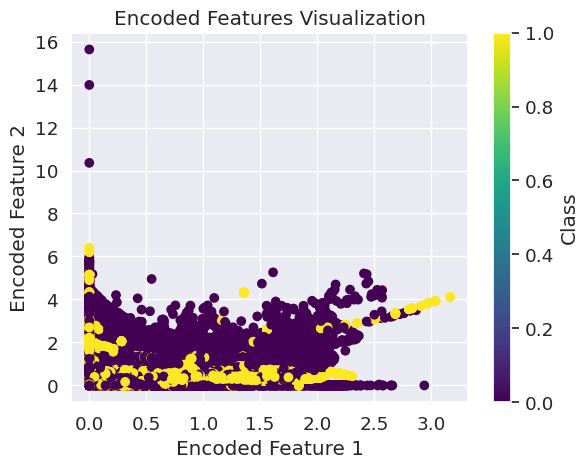

In [73]:
# this is with the whole autoencoder
import matplotlib.pyplot as plt

scatter = plt.scatter(encoded_features_train_ENC[:, 1], encoded_features_train_ENC[:, 0], c=y_train_target, cmap='viridis')
# Add a colorbar
plt.colorbar(scatter, label='Class')
plt.title('Encoded Features Visualization')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.savefig('CICIDS2014_COMP_16_BEst_FeE_Vclass2_01.png')

In [74]:
import xgboost as xgb

# Load the saved model
model = xgb.XGBClassifier()
model.load_model('/kaggle/input/opeda_gwoxb/tensorflow2/default/1/my_model.json')

In [75]:
%%time
model.fit(encoded_features_train_EDA, y_train_target) #encoded_features_train_ENC
# Predict using the GWO_XGB classifier

CPU times: user 2min 17s, sys: 88.7 ms, total: 2min 17s
Wall time: 35.8 s


XGBClassifier(base_score='8.351164E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [76]:
%%time
y_predxg = model.predict(encoded_features_test_EDA) #encoded_features_test_ENC

CPU times: user 3.9 s, sys: 0 ns, total: 3.9 s
Wall time: 982 ms


In [77]:
cr = classification_report(y_test_target, y_predxg)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    424410
           1       0.99      1.00      0.99    424409

    accuracy                           0.99    848819
   macro avg       0.99      0.99      0.99    848819
weighted avg       0.99      0.99      0.99    848819



with para-gwo+xgboost

In [87]:
x_train_input_SC.shape, y_train_target.shape, x_test_input_SC.shape, y_test_target.shape

((1980577, 50), (1980577,), (848819, 50), (848819,))

optimized XGB

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
import random

# Objective function
def objective_function(hyperparameters):
    xgb_model = xgb.XGBClassifier(**hyperparameters)
    xgb_model.fit(encoded_features_train_ENC, y_train_target)
    predictions = xgb_model.predict(encoded_features_test_ENC)
    accuracy = accuracy_score(y_test_target, predictions)
    return accuracy

# Initialize the Grey Wolves population
def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        hyperparameters = {
            'learning_rate': np.random.uniform(0.01, 0.3),
            'max_depth': np.random.randint(8, 20),
            'subsample': np.random.uniform(0.6, 1.0),
            'min_child_weight': np.random.uniform(0.5, 2.0),
            'n_estimators': np.random.randint(100, 300),
            'max_leaf_nodes': np.random.randint(1, 9),
            'colsample_bytree': np.random.uniform(0.5, 0.9),
            'gamma': 0.1,
            'scale_pos_weight':np.random.uniform(1, 20),
            'seed': 42
        }
        population.append(hyperparameters)
    return population

# Updating Positions of wolf
def update_wolf_positions(population, alpha, beta, delta, a, A, C):
    for wolf in population:
        for key in wolf:
            if key in alpha:
                D_alpha = abs(C * alpha[key] - wolf[key])
                X1 = alpha[key] - A * D_alpha
                wolf[key] = X1
            elif key in beta:
                D_beta = abs(C * beta[key] - wolf[key])
                X2 = beta[key] - A * D_beta
                wolf[key] = X2
            elif key in delta:
                D_delta = abs(C * delta[key] - wolf[key])
                X3 = delta[key] - A * D_delta
                wolf[key] = X3
            else:
                choice = random.choice([alpha, beta, delta])
                D_choice = abs(C * choice[key] - wolf[key])
                X_choice = choice[key] - A * D_choice
                wolf[key] = X_choice

# Evaluate Fitness
def evaluate_fitness(population):
    fitness_scores = []
    for wolf in population:
        fitness_scores.append(objective_function(wolf))
    return fitness_scores

# Termination criteria
max_iterations = 50 #50
convergence_threshold = 1e-6 # to 1e-4
max_consecutive_iterations = 5

# Initialize best_hyperparameters with some default values
best_hyperparameters = {
    'max_depth': 5,
    'learning_rate': 0.5,
    'n_estimators': 100,
    'min_child_weight': 1.0,
    'scale_pos_weight':1,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'max_leaf_nodes': 5,
    'seed': 42
}

best_fitness = objective_function(best_hyperparameters)
consecutive_iterations = 5 # 10

# Main GWO optimization loop
for iteration in range(max_iterations):
    # Initialize alpha, beta, delta wolves
    alpha, beta, delta = None, None, None
    population = initialize_population(population_size=50)  # 20 Set your desired population size
    
    a = 2.0
    A = 2 * a * (1 - (iteration / max_iterations))  # Encouraging exploration
    
    # Update alpha, beta, delta based on fitness
    fitness_scores = evaluate_fitness(population)
    alpha_idx = fitness_scores.index(min(fitness_scores))
    alpha = population[alpha_idx].copy()
    beta_idx = fitness_scores.index(sorted(fitness_scores)[1])
    beta = population[beta_idx].copy()
    delta_idx = fitness_scores.index(sorted(fitness_scores)[2])
    delta = population[delta_idx].copy()
    
    # Update wolf positions
    update_wolf_positions(population, alpha, beta, delta, a, A, 2 * random.random() - 1)
    
    # Return the best hyperparameters found
    best_hyperparameters = alpha  # Choose alpha as the best set
    
    current_fitness = objective_function(best_hyperparameters)
    
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        consecutive_iterations = 0
    else:
        consecutive_iterations += 1
    
    if consecutive_iterations >= max_consecutive_iterations:
        print("Convergence criteria met. Terminating optimization.")
        break
    
    if iteration == max_iterations - 1:
        print("Maximum iterations reached. Terminating optimization.")

print("Final Hyperparameters:", best_hyperparameters)

In [28]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score                    #8 scale_pos_weight= 0.508668903016084,
xgb_classifier = xgb.XGBClassifier(n_estimators=150, learning_rate = 0.04475, max_depth = 8, scale_pos_weight= 17.508668903016084,
                         min_child_weight= 0.8954022553993488, subsample= 0.7513841858486106 ,colsample_bytree= 0.6627678651590391, 
                        max_leaf_nodes = 10, gamma = 0.1, seed = 42)

xgb_classifier.fit(x_train_input_SC, y_train_target) #encoded_features_train_ENC
# Predict using the XGBoost classifier
y_predxgp = xgb_classifier.predict(x_test_input_SC) #encoded_features_test_ENC 
cr = classification_report(y_test_target, y_predxgp)

XGBoost
Confusion Matrix:
[[423353   1057]
 [    17 424392]]
Performance Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    424410
           1       1.00      1.00      1.00    424409

    accuracy                           1.00    848819
   macro avg       1.00      1.00      1.00    848819
weighted avg       1.00      1.00      1.00    848819

AUC: 0.9987347140264654


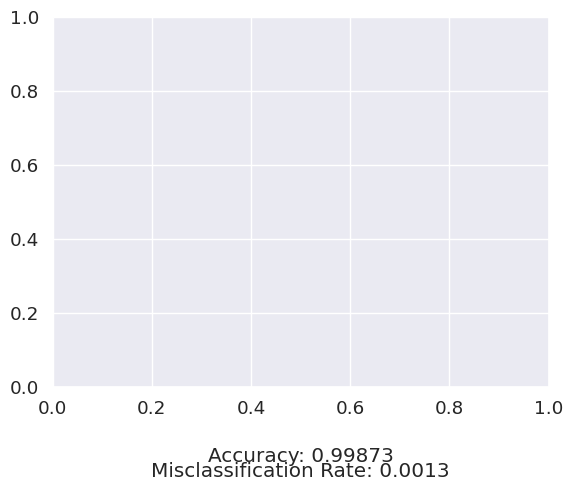

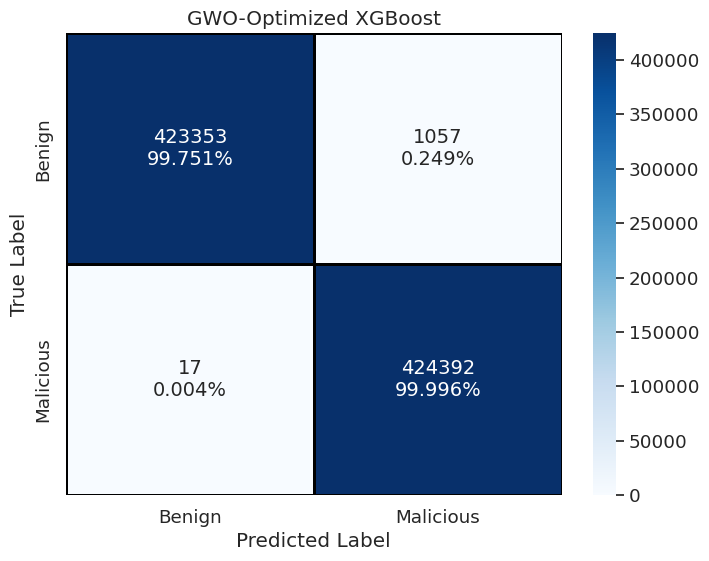

<Figure size 640x480 with 0 Axes>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define the confusion matrix heatmap function
def confusionMatrixHeatMap(cm, title):
    # Calculate row percentages
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_percentage = cm / cm_sum * 100

    # Creating a custom label for each cell with both raw counts and percentage values
    labels = np.array([["{}\n{:.3f}%".format(value, percentage) for value, percentage in zip(row, percentage_row)]
                       for row, percentage_row in zip(cm, cm_percentage)])

    # Categories
    categories = ['Benign', 'Malicious']

    # Set a fixed color range for the heatmap to make cells similar in color intensity
    max_value = np.max(cm)  # Maximum value in the confusion matrix

    # Create a heatmap of the confusion matrix with raw counts and percentages
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True,
                annot_kws={"size": 14}, linewidths=2, linecolor='black',
                xticklabels=categories, yticklabels=categories, vmin=0, vmax=max_value)
    # Set labels, title, and axis ticks
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

    # Show the plot
    plt.savefig('confusion_matrix_xgboost.png')
    plt.show()

print("XGBoost")

# Generate report
cm = confusion_matrix(y_test_target, y_predxgp )
cr = classification_report(y_test_target, y_predxgp )
auc = roc_auc_score(y_test_target, y_predxgp )

# calculate accuracy and misclassification rate
total_samples = len(y_test_target)
correct_predictions = sum(y_test_target == y_predxgp)
incorrect_predictions = total_samples - correct_predictions
accuracy = correct_predictions / total_samples
misclassification_rate = incorrect_predictions / total_samples

# add accuracy and misclassification rate to the heatmap
plt.text(0.5, -0.1, f'\n\n\nAccuracy: {accuracy:.4f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2, f'\nMisclassification Rate: {misclassification_rate:.4f}', ha='center', va='center', transform=plt.gca().transAxes)

print("Confusion Matrix:")
print(cm)

print("Performance Matrix:")
print(cr)

print("AUC:", auc)

# Plot the confusion matrix heatmap with raw counts and percentages
confusionMatrixHeatMap(cm, title="GWO-Optimized XGBoost")
plt.savefig('CICIDS2017_CM.png')

# ROC

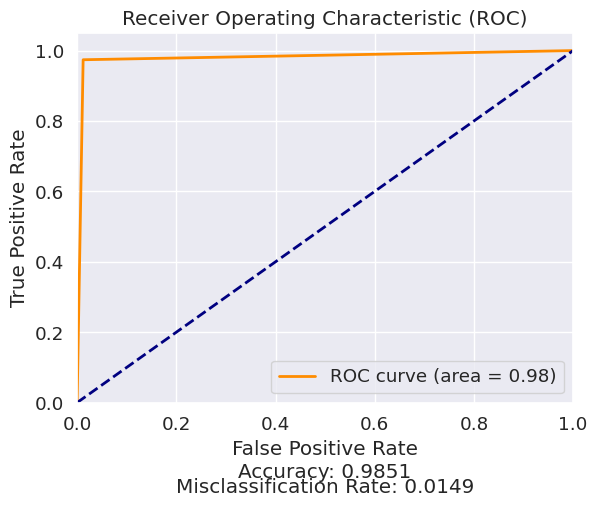

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true contains the true binary labels and y_scores contains the predicted probabilities

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test_target, y_predxg)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

# Add accuracy and misclassification rate to the plot
plt.text(0.5, -0.1, f'\n\n\nAccuracy: {accuracy:.4f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2, f'\nMisclassification Rate: {misclassification_rate:.4f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.savefig('ROC_OPXGB_xgboost.png')
plt.show()

In [86]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
import random

# Objective function to maximize (in this case, accuracy)
def objective_function(hyperparameters):
    xgb_model = xgb.XGBClassifier(**hyperparameters)
    xgb_model.fit(encoded_features_train_ENC, y_train_target)
    predictions = xgb_model.predict(encoded_features_test_ENC)
    accuracy = accuracy_score(encoded_y_test, predictions)
    return accuracy

# Initialize the Grey Wolves
def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        hyperparameters = {
            'learning_rate': np.random.uniform(0.01, 0.3),
            'max_depth': np.random.randint(8, 20),
            'subsample': np.random.uniform(0.6, 1.0),
            'min_child_weight': np.random.uniform(0.5, 2.0),
            'n_estimators': np.random.randint(100, 300),
            'max_leaf_nodes': np.random.randint(1, 9),
            'colsample_bytree': np.random.uniform(0.5, 0.9),
            'gamma': 0.1,
            'scale_pos_weight':np.random.uniform(1, 20),
            'seed': 42
        }
        population.append(hyperparameters)
    return population

# Update Wolf Positions
def update_wolf_positions(population, alpha, beta, delta, a, A, C):
    for wolf in population:
        for key in wolf:
            if key in alpha:
                D_alpha = abs(C * alpha[key] - wolf[key])
                X1 = alpha[key] - A * D_alpha
                wolf[key] = X1
            elif key in beta:
                D_beta = abs(C * beta[key] - wolf[key])
                X2 = beta[key] - A * D_beta
                wolf[key] = X2
            elif key in delta:
                D_delta = abs(C * delta[key] - wolf[key])
                X3 = delta[key] - A * D_delta
                wolf[key] = X3
            else:
                choice = random.choice([alpha, beta, delta])
                D_choice = abs(C * choice[key] - wolf[key])
                X_choice = choice[key] - A * D_choice
                wolf[key] = X_choice

# Evaluate Fitness
def evaluate_fitness(population):
    fitness_scores = []
    for wolf in population:
        fitness_scores.append(objective_function(wolf))
    return fitness_scores

# Define termination criteria
max_iterations = 50 #50
convergence_threshold = 1e-6 # to 1e-4
max_consecutive_iterations = 5

# Initialize best_hyperparameters with some default values
best_hyperparameters = {
    'max_depth': 5,
    'learning_rate': 0.5,
    'n_estimators': 100,
    'min_child_weight': 1.0,
    'scale_pos_weight':1,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'max_leaf_nodes': 5,
    'seed': 42
}

best_fitness = objective_function(best_hyperparameters)
consecutive_iterations = 5 # 10

# Main GWO optimization loop
for iteration in range(max_iterations):
    # Initialize alpha, beta, delta wolves
    alpha, beta, delta = None, None, None
    population = initialize_population(population_size=50)  # 20 Set your desired population size
    
    a = 2.0
    A = 2 * a * (1 - (iteration / max_iterations))  # Encouraging exploration
    
    # Update alpha, beta, delta based on fitness
    fitness_scores = evaluate_fitness(population)
    alpha_idx = fitness_scores.index(min(fitness_scores))
    alpha = population[alpha_idx].copy()
    beta_idx = fitness_scores.index(sorted(fitness_scores)[1])
    beta = population[beta_idx].copy()
    delta_idx = fitness_scores.index(sorted(fitness_scores)[2])
    delta = population[delta_idx].copy()
    
    # Update wolf positions
    update_wolf_positions(population, alpha, beta, delta, a, A, 2 * random.random() - 1)
    
    # Return the best hyperparameters found
    best_hyperparameters = alpha  # Choose alpha as the best set
    
    current_fitness = objective_function(best_hyperparameters)
    
    if current_fitness > best_fitness:
        best_fitness = current_fitness
        consecutive_iterations = 0
    else:
        consecutive_iterations += 1
    
    if consecutive_iterations >= max_consecutive_iterations:
        print("Convergence criteria met. Terminating optimization.")
        break
    
    if iteration == max_iterations - 1:
        print("Maximum iterations reached. Terminating optimization.")

print("Final Hyperparameters:", best_hyperparameters)

Convergence criteria met. Terminating optimization.
Final Hyperparameters: {'learning_rate': 0.11754239484708826, 'max_depth': 8, 'subsample': 0.7513841858486106, 'min_child_weight': 0.8954022553993488, 'n_estimators': 218, 'max_leaf_nodes': 5, 'colsample_bytree': 0.6627678651590391, 'gamma': 0.1, 'scale_pos_weight': 19.738668903016084, 'seed': 42}
